# Supervised Learning notebook

This notebook will be for finding inferences on the given obesity dataset with supervised learning algorithms.

The goal will be to see if the feature variables can predict the correct obesity classification reliably.

##  Data Preparation

#### Initial import and data check

In [1]:
# initial imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)

# Set random seed
np.random.seed(13)   # unlucky for some

In [2]:
# import obesity data
obesity_df = pd.read_csv("assignment_dataset/ObesityDataSet_raw_and_data_sinthetic.csv")

#### Redo ordinal targets and X dataset

In [3]:
# Ordinal target mapping for 7 obesity levels
obesity_map = {
    'Insufficient_Weight': 0,
    'Normal_Weight': 1,
    'Overweight_Level_I': 2,
    'Overweight_Level_II': 3,
    'Obesity_Type_I': 4,
    'Obesity_Type_II': 5,
    'Obesity_Type_III': 6
}

# Create encoded target
y = obesity_df['NObeyesdad'].map(obesity_map)

# Reverse mapping for later visualisation. Swap k and v pairs.
reverse_map = {v: k for k, v in obesity_map.items()}

In [4]:
# Separate features from target
X = obesity_df.drop('NObeyesdad', axis=1)

#### Train test split stratified

In [5]:
# Stratified train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=13,    # unlucky for some
    stratify=y  # keeps classes even
)

#### Feature encoding

Rather than do individual cells, do it all as a function?

In [6]:
# define groups
numerical_features = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
binary_features = ['family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']
ordinal_features = ['CAEC', 'CALC']
nominal_features = ['Gender', 'MTRANS']

In [7]:
# function to encode features
def encode_features(df):
    """Apply encoding to feature dataframe"""
    df_enc = df.copy()

    # binary = yes/no -> 1/0
    for col in binary_features:
        df_enc[col] = (df_enc[col] == 'yes').astype(int)

    # ordinal =  map to 0/1/2/3
    ordinal_mapping = {'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3}
    for col in ordinal_features:
        df_enc[col] = df_enc[col].map(ordinal_mapping)

    # nominal = one-hot encode (drop_first=True)
    df_enc = pd.get_dummies(df_enc, columns=nominal_features, drop_first=True)

    return df_enc

In [8]:
# Apply encoding to train and test
X_train_enc = encode_features(X_train)
X_test_enc = encode_features(X_test)

In [9]:
X_train_enc

,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,Gender_Male,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
1063,45.000000,1.675953,79.668320,1,1,2.598051,3.000000,1,0,1.000000,0,0.000000,0.000000,0,False,False,False,False,False
118,23.000000,1.620000,53.000000,1,1,2.000000,3.000000,1,0,2.000000,0,1.000000,1.000000,1,True,False,False,True,False
877,18.000000,1.647971,68.818893,1,1,2.000000,1.411685,1,0,1.859089,0,0.000000,1.306000,0,False,False,False,True,False
480,18.000000,1.570000,50.000000,0,1,2.000000,3.000000,1,0,1.000000,0,0.000000,1.000000,1,False,False,False,True,False
447,19.000000,1.800000,87.000000,1,1,2.000000,4.000000,1,0,2.000000,0,2.000000,1.000000,1,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1633,30.475248,1.801368,121.094257,1,1,2.328469,3.000000,1,0,2.001208,0,0.800487,0.176678,1,True,False,False,False,False
541,19.717249,1.688426,49.660995,0,0,2.714447,3.000000,2,0,2.000000,0,1.903182,1.000000,1,False,False,False,True,False
1317,24.184891,1.768834,97.449743,1,1,2.000000,3.000000,1,0,2.973729,0,2.491642,1.365950,0,True,False,False,True,False
1035,17.971574,1.720379,85.000000,1,1,2.000000,3.000000,1,0,2.802498,0,1.000000,0.417580,1,True,False,False,True,False


In [10]:
X_test_enc

,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,Gender_Male,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
743,18.381382,1.722547,53.783977,1,1,2.000000,3.131032,1,0,2.072194,0,1.487987,2.000000,1,True,False,False,True,False
280,21.000000,1.750000,62.000000,0,1,3.000000,4.000000,2,1,2.000000,0,0.000000,0.000000,1,True,False,False,True,False
261,28.000000,1.700000,73.000000,1,0,2.000000,3.000000,2,0,2.000000,1,2.000000,0.000000,1,False,False,False,False,True
1983,20.908785,1.700996,126.490236,1,1,3.000000,3.000000,1,0,1.242832,0,0.530925,0.575969,1,False,False,False,True,False
85,23.000000,1.650000,58.500000,1,0,2.000000,3.000000,1,0,2.000000,0,0.000000,0.000000,0,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,18.000000,1.750000,85.000000,1,0,2.000000,3.000000,1,0,3.000000,0,1.000000,0.000000,1,True,False,False,True,False
1083,24.122589,1.856759,95.887056,1,1,1.116068,2.449067,1,0,2.000000,0,0.926350,1.971170,1,True,False,False,True,False
967,32.278869,1.646020,74.147443,1,1,2.885178,2.562895,1,0,1.017006,0,0.588673,0.916291,1,False,False,False,False,False
1560,25.300208,1.765258,114.330023,1,1,1.562804,3.000000,1,0,2.075493,0,1.553734,0.000436,1,True,False,False,True,False


Encoding looks good, although I see warnings for duplicate rows. 16 (1%) in training set and 4 (0.8%) in test set.

#### Scale the features

To stop data leaking we fit and trasnform on the training set and only transform on the test set.

In [11]:
# Set up standard scaler
scaler = StandardScaler()

In [12]:
# Fit and transform on training set, ONLY transform on test set
X_train_scaled = scaler.fit_transform(X_train_enc)
X_test_scaled = scaler.transform(X_test_enc)

In [13]:
# convert back to dataframes to keep column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_enc.columns, index=X_train_enc.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_enc.columns, index=X_test_enc.index)

In [14]:
print(X_train_scaled.mean().mean())   # should be 0
print(X_train_scaled.std().mean())   # should be 1

8.937300885136249e-17
1.0003160056959908


In [15]:
print(X_test_scaled.mean().mean())   # should be 0 or very near it
print(X_test_scaled.std().mean())   # should be 1 or very near it

0.010287451224926508
0.9820207470168661


## Logistic Regression

Logistic regression is promising for ordinal targets. Let's try that first.

#### Training

In [16]:
# Automatically multiclassify with LogisticRegression
log_reg = LogisticRegression(
    solver='lbfgs',
    max_iter=100,   # make sure model converges
    random_state=13,
    C=1.0
)

# Train the model
log_reg.fit(X_train_scaled, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",13
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multi

In [17]:
# Check convergence
print(log_reg.n_iter_[0])
print(log_reg.classes_)  # should be [0, 1, 2, 3, 4, 5, 6]
print(log_reg.coef_.shape)  # should 7 * 19

70
[0 1 2 3 4 5 6]
(7, 19)


#### Testing / Performance

In [18]:
# Make predictions
y_train_pred = log_reg.predict(X_train_scaled)
y_test_pred = log_reg.predict(X_test_scaled)

# Get prediction probabilities
y_test_proba = log_reg.predict_proba(X_test_scaled)

# Calculate accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

In [19]:
print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Difference: {abs(train_accuracy - test_accuracy):.4f}")

Training Accuracy: 0.8983 (89.83%)
Test Accuracy: 0.8750 (87.50%)
Difference: 0.0233


In [20]:
# Generate classification report
target_names = [reverse_map[i] for i in sorted(reverse_map.keys())]

print(classification_report(y_test, y_test_pred, target_names=target_names, digits=3))

# Calculated F1 scores
weighted_f1 = f1_score(y_test, y_test_pred, average='weighted')
macro_f1 = f1_score(y_test, y_test_pred, average='macro')

                     precision    recall  f1-score   support

Insufficient_Weight      0.904     0.971     0.936        68
      Normal_Weight      0.855     0.736     0.791        72
 Overweight_Level_I      0.732     0.822     0.774        73
Overweight_Level_II      0.790     0.681     0.731        72
     Obesity_Type_I      0.890     0.920     0.905        88
    Obesity_Type_II      0.936     0.986     0.961        74
   Obesity_Type_III      1.000     0.988     0.994        81

           accuracy                          0.875       528
          macro avg      0.872     0.872     0.870       528
       weighted avg      0.875     0.875     0.873       528



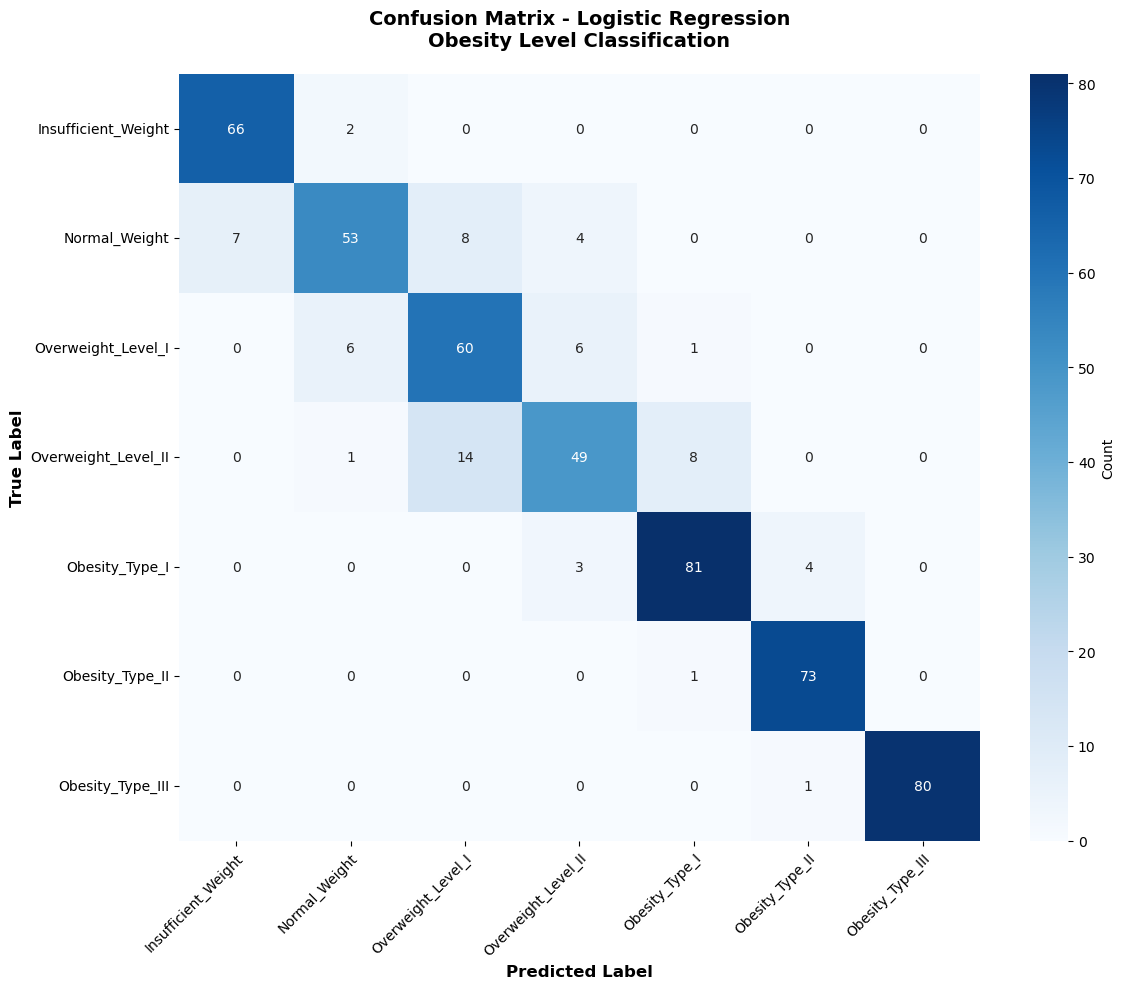

In [21]:
# confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Create visualisation
fig, ax = plt.subplots(figsize=(12, 10))

# Plot heatmap
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names,
    cbar_kws={'label': 'Count'},
    ax=ax
)

ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_title('Confusion Matrix - Logistic Regression\nObesity Level Classification',
             fontsize=14, fontweight='bold', pad=20)

# Rotate labels for readability
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
plt.setp(ax.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()

## Decision Tree Classifier

Considering the background of this dataset, a decsion tree classifier may work well.

This time we don't need to use scaled data

In [22]:
# decision tree classifier
dt_clf = DecisionTreeClassifier(
    random_state=13,  # unlcuky for some
    criterion='gini',  # Gini impurity for splits
    max_depth=None,   # No depth limit initially
    min_samples_split=2,
    min_samples_leaf=1
)

# Train the model
print("Training decision tree classifier...")
dt_clf.fit(X_train_enc, y_train)
print("✓ Model training completed!")

# Model info
print(f"\nTree depth: {dt_clf.get_depth()}")
print(f"Number of leaves: {dt_clf.get_n_leaves()}")
print(f"Number of features used: {(dt_clf.feature_importances_ > 0).sum()} / {len(X_train_enc.columns)}")

Training decision tree classifier...
✓ Model training completed!

Tree depth: 13
Number of leaves: 108
Number of features used: 15 / 19


In [23]:
# Make predictions
y_train_pred_dt = dt_clf.predict(X_train_enc)
y_test_pred_dt = dt_clf.predict(X_test_enc)

# Calculate accuracy scores
train_accuracy_dt = accuracy_score(y_train, y_train_pred_dt)
test_accuracy_dt = accuracy_score(y_test, y_test_pred_dt)

print("="*60)
print("DECISION TREE PERFORMANCE")
print("="*60)
print(f"Training Accuracy: {train_accuracy_dt:.4f} ({train_accuracy_dt*100:.2f}%)")
print(f"Test Accuracy:     {test_accuracy_dt:.4f} ({test_accuracy_dt*100:.2f}%)")
print(f"Difference:        {abs(train_accuracy_dt - test_accuracy_dt):.4f}")

print(f"\nTree depth: {dt_clf.get_depth()}")
print(f"Number of leaves: {dt_clf.get_n_leaves()}")

DECISION TREE PERFORMANCE
Training Accuracy: 1.0000 (100.00%)
Test Accuracy:     0.9242 (92.42%)
Difference:        0.0758

Tree depth: 13
Number of leaves: 108


In [24]:
# Classification report
target_names = [reverse_map[i] for i in sorted(reverse_map.keys())]

print("\n" + "="*80)
print("CLASSIFICATION REPORT - DECISION TREE (Test Set)")
print("="*80)
print(classification_report(y_test, y_test_pred_dt, target_names=target_names, digits=3))

# Calculate weighted F1 score
weighted_f1_dt = f1_score(y_test, y_test_pred_dt, average='weighted')
macro_f1_dt = f1_score(y_test, y_test_pred_dt, average='macro')

print(f"\nWeighted F1-Score: {weighted_f1_dt:.4f}")
print(f"Macro F1-Score:    {macro_f1_dt:.4f}")


CLASSIFICATION REPORT - DECISION TREE (Test Set)
                     precision    recall  f1-score   support

Insufficient_Weight      0.913     0.926     0.920        68
      Normal_Weight      0.857     0.750     0.800        72
 Overweight_Level_I      0.805     0.904     0.852        73
Overweight_Level_II      0.917     0.917     0.917        72
     Obesity_Type_I      0.988     0.966     0.977        88
    Obesity_Type_II      0.974     1.000     0.987        74
   Obesity_Type_III      1.000     0.988     0.994        81

           accuracy                          0.924       528
          macro avg      0.922     0.922     0.921       528
       weighted avg      0.925     0.924     0.924       528


Weighted F1-Score: 0.9239
Macro F1-Score:    0.9208


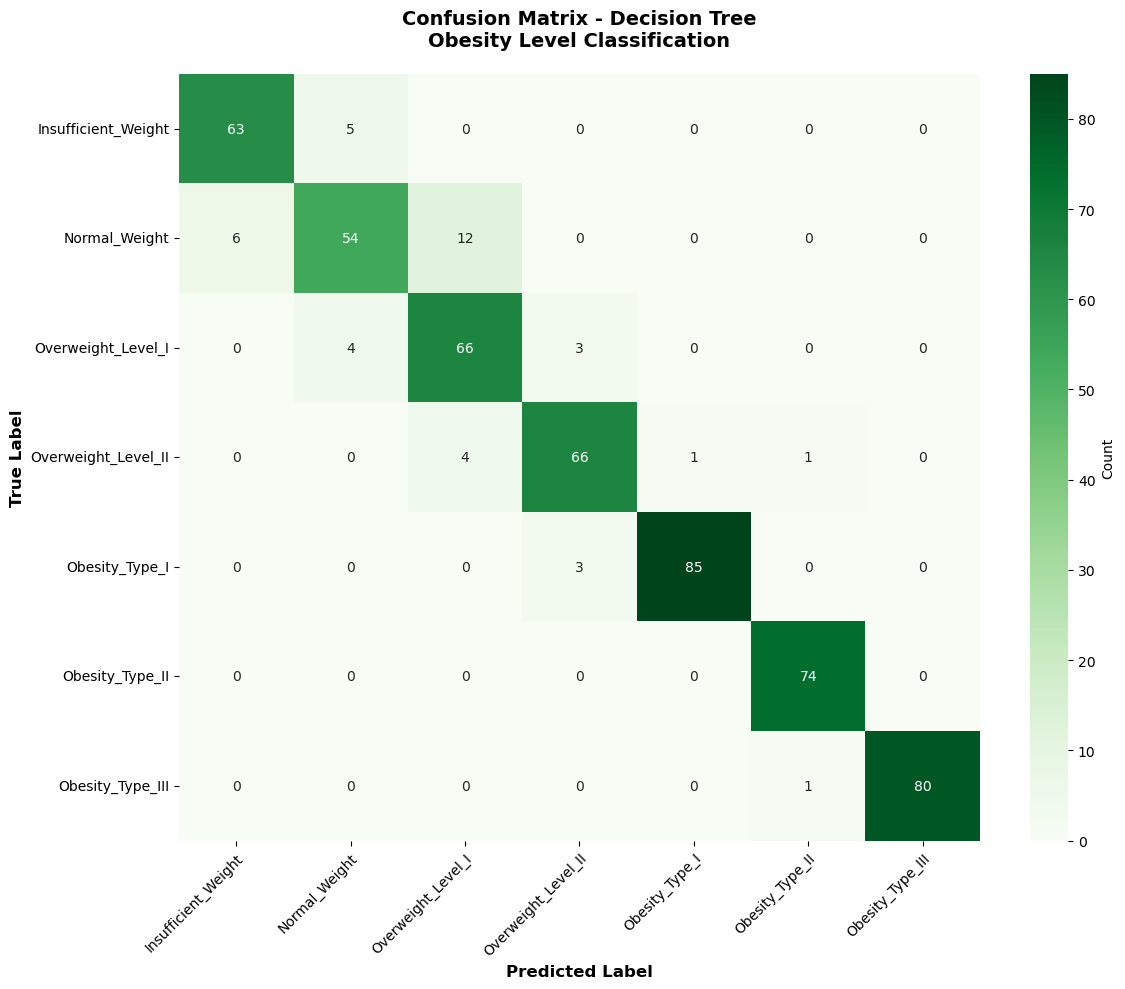

In [25]:
# Confusion matrix
cm_dt = confusion_matrix(y_test, y_test_pred_dt)

fig, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(
    cm_dt,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=target_names,
    yticklabels=target_names,
    cbar_kws={'label': 'Count'},
    ax=ax
)

ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_title('Confusion Matrix - Decision Tree\nObesity Level Classification',
             fontsize=14, fontweight='bold', pad=20)

plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
plt.setp(ax.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()


FEATURE IMPORTANCE - DECISION TREE
                       feature  importance
                        Weight    0.441259
                        Height    0.230204
                   Gender_Male    0.156566
                           Age    0.054159
                          CALC    0.023138
                          FAVC    0.022671
                          FCVC    0.015967
                           TUE    0.013001
                          CAEC    0.012894
                           NCP    0.012061
                          CH2O    0.010052
family_history_with_overweight    0.002582
                         SMOKE    0.002392
                MTRANS_Walking    0.002317
                           FAF    0.000738
                           SCC    0.000000
                   MTRANS_Bike    0.000000
              MTRANS_Motorbike    0.000000
  MTRANS_Public_Transportation    0.000000


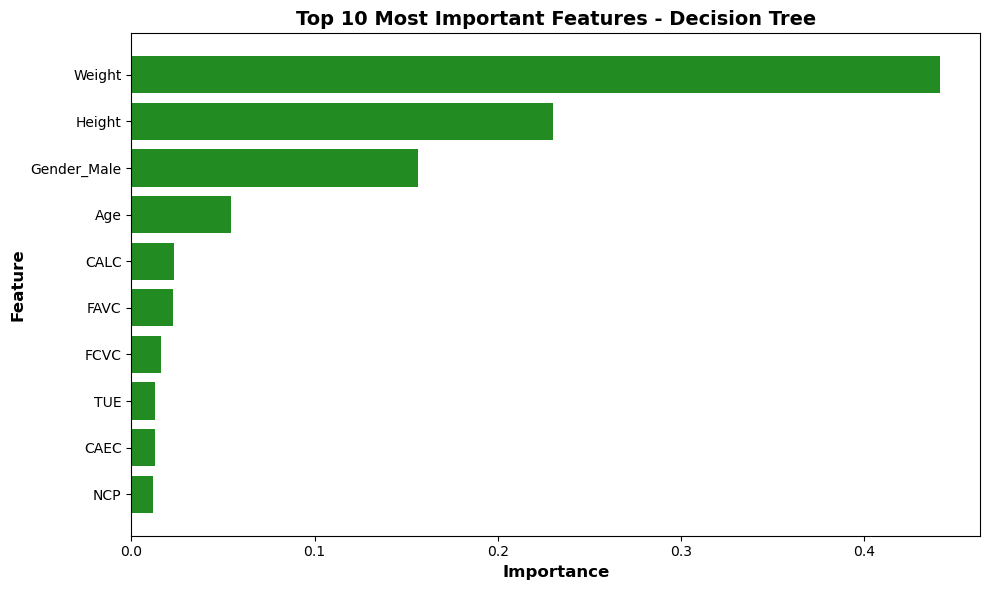


Top 3 most important features:
  Weight: 0.4413
  Height: 0.2302
  Gender_Male: 0.1566


In [26]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_train_enc.columns,
    'importance': dt_clf.feature_importances_
}).sort_values('importance', ascending=False)

print("\n" + "="*60)
print("FEATURE IMPORTANCE - DECISION TREE")
print("="*60)
print(feature_importance.to_string(index=False))

# Visualise top 10 features
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(10)

plt.barh(range(len(top_features)), top_features['importance'], color='forestgreen')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title('Top 10 Most Important Features - Decision Tree', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()  # Highest importance at top
plt.tight_layout()
plt.show()

print(f"\nTop 3 most important features:")
for i, row in feature_importance.head(3).iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

In [27]:
# Train a pruned decision tree with constraints
dt_pruned = DecisionTreeClassifier(
    random_state=13,
    criterion='gini',
    max_depth=8, # Limit tree depth
    min_samples_split=10, # Require more samples to split
    min_samples_leaf=5  # Require more samples in leaves
)

dt_pruned.fit(X_train_enc, y_train)

print(f"\nPruned tree depth: {dt_pruned.get_depth()} (was 13)")
print(f"Number of leaves: {dt_pruned.get_n_leaves()} (was 108)")

# Evaluate pruned model
y_train_pred_pruned = dt_pruned.predict(X_train_enc)
y_test_pred_pruned = dt_pruned.predict(X_test_enc)

train_acc_pruned = accuracy_score(y_train, y_train_pred_pruned)
test_acc_pruned = accuracy_score(y_test, y_test_pred_pruned)

print(f"\nPruned model performance:")
print(f"  Training Accuracy: {train_acc_pruned:.4f} ({train_acc_pruned*100:.2f}%)")
print(f"  Test Accuracy: {test_acc_pruned:.4f} ({test_acc_pruned*100:.2f}%)")
print(f"  Gap: {train_acc_pruned - test_acc_pruned:.4f}")

print(f"\nComparison:")
print(f"  Unpruned test acc: {test_accuracy_dt:.4f}")
print(f"  Pruned test acc: {test_acc_pruned:.4f}")
print(f"  Difference: {test_acc_pruned - test_accuracy_dt:+.4f}")


Pruned tree depth: 8 (was 13)
Number of leaves: 61 (was 108)

Pruned model performance:
  Training Accuracy: 0.9526 (95.26%)
  Test Accuracy: 0.9053 (90.53%)
  Gap: 0.0473

Comparison:
  Unpruned test acc: 0.9242
  Pruned test acc: 0.9053
  Difference: -0.0189


Prunning helps with overfitting but drops test accuracy

## Random Forrest

Now for the king of ensemble. RANDOM FORREST!!

In [28]:
# Initialise Random Forest
rf_clf = RandomForestClassifier(
    n_estimators=100,      # Number of trees
    random_state=13,
    max_depth=None,        # Let trees grow
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt', # sqrt(n_features) for each split
    n_jobs=-1  # Use all cores (please don't break)
)

print("Training Random Forest classifier...")
print("(This may take a moment with 100 trees...)")
rf_clf.fit(X_train_enc, y_train)
print("✓ Random Forest training completed!")

# Make predictions
y_train_pred_rf = rf_clf.predict(X_train_enc)
y_test_pred_rf = rf_clf.predict(X_test_enc)

# Evaluate
train_acc_rf = accuracy_score(y_train, y_train_pred_rf)
test_acc_rf = accuracy_score(y_test, y_test_pred_rf)

print("\n" + "="*60)
print("RANDOM FOREST PERFORMANCE")
print("="*60)
print(f"Training Accuracy: {train_acc_rf:.4f} ({train_acc_rf*100:.2f}%)")
print(f"Test Accuracy:     {test_acc_rf:.4f} ({test_acc_rf*100:.2f}%)")
print(f"Difference:        {abs(train_acc_rf - test_acc_rf):.4f}")

if train_acc_rf - test_acc_rf > 0.05:
    print("\n⚠️  Some overfitting present")
else:
    print("\n✓ Excellent generalisation")

Training Random Forest classifier...
(This may take a moment with 100 trees...)
✓ Random Forest training completed!

RANDOM FOREST PERFORMANCE
Training Accuracy: 1.0000 (100.00%)
Test Accuracy:     0.9470 (94.70%)
Difference:        0.0530

⚠️  Some overfitting present



CLASSIFICATION REPORT - RANDOM FOREST (Test Set)
                     precision    recall  f1-score   support

Insufficient_Weight      1.000     0.971     0.985        68
      Normal_Weight      0.829     0.944     0.883        72
 Overweight_Level_I      0.926     0.863     0.894        73
Overweight_Level_II      0.889     0.889     0.889        72
     Obesity_Type_I      0.988     0.966     0.977        88
    Obesity_Type_II      1.000     1.000     1.000        74
   Obesity_Type_III      1.000     0.988     0.994        81

           accuracy                          0.947       528
          macro avg      0.948     0.946     0.946       528
       weighted avg      0.949     0.947     0.947       528


Weighted F1-Score: 0.9475
Macro F1-Score:    0.9459


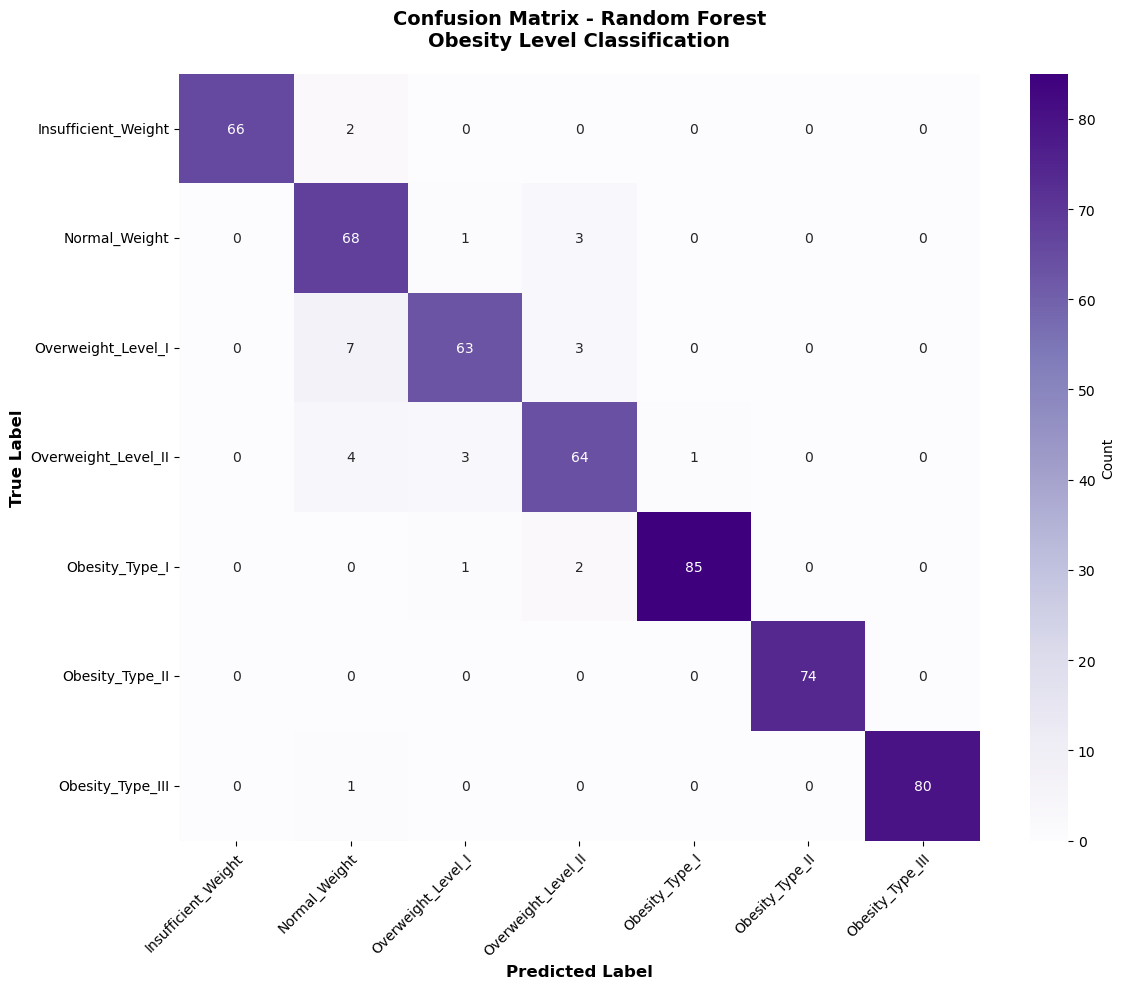

In [29]:
# Classification report
target_names = [reverse_map[i] for i in sorted(reverse_map.keys())]

print("\n" + "="*80)
print("CLASSIFICATION REPORT - RANDOM FOREST (Test Set)")
print("="*80)
print(classification_report(y_test, y_test_pred_rf, target_names=target_names, digits=3))

# Calculate F1 scores
weighted_f1_rf = f1_score(y_test, y_test_pred_rf, average='weighted')
macro_f1_rf = f1_score(y_test, y_test_pred_rf, average='macro')

print(f"\nWeighted F1-Score: {weighted_f1_rf:.4f}")
print(f"Macro F1-Score:    {macro_f1_rf:.4f}")

# Confusion matrix
cm_rf = confusion_matrix(y_test, y_test_pred_rf)

fig, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(
    cm_rf,
    annot=True,
    fmt='d',
    cmap='Purples',
    xticklabels=target_names,
    yticklabels=target_names,
    cbar_kws={'label': 'Count'},
    ax=ax
)

ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_title('Confusion Matrix - Random Forest\nObesity Level Classification',
             fontsize=14, fontweight='bold', pad=20)

plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
plt.setp(ax.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()


FEATURE IMPORTANCE - RANDOM FOREST
                       feature  importance
                        Weight    0.319997
                           Age    0.098700
                        Height    0.097580
                          FCVC    0.092725
                   Gender_Male    0.056283
                           TUE    0.052052
                           NCP    0.050017
                          CH2O    0.046457
                           FAF    0.043786
                          CAEC    0.037101
                          CALC    0.029223
family_history_with_overweight    0.028318
  MTRANS_Public_Transportation    0.018709
                          FAVC    0.016683
                           SCC    0.005187
                MTRANS_Walking    0.003718
                         SMOKE    0.002181
              MTRANS_Motorbike    0.000700
                   MTRANS_Bike    0.000583


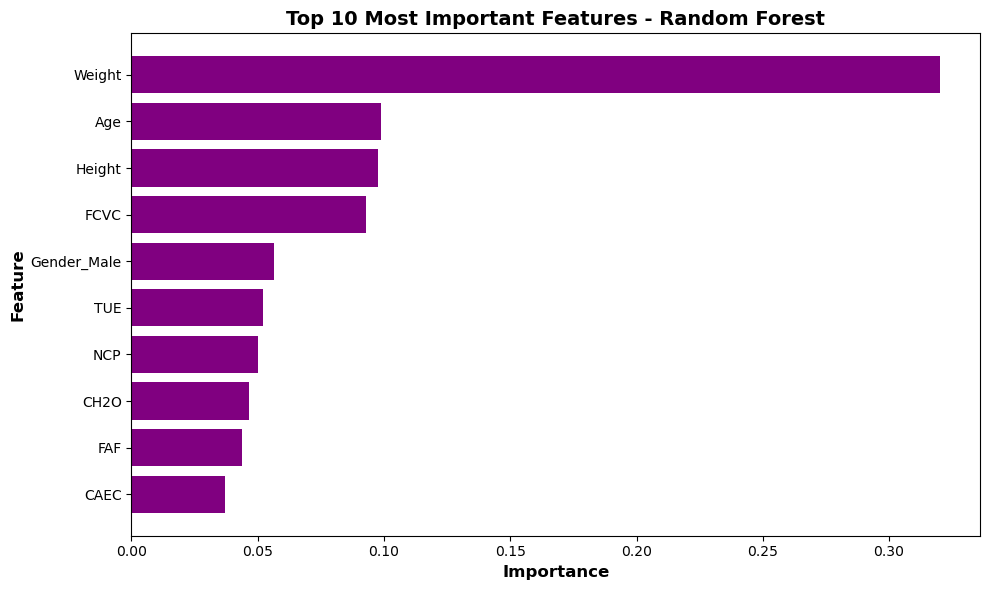


Top 5 most important features:
  1. Weight: 0.3200
  2. Age: 0.0987
  3. Height: 0.0976
  4. FCVC: 0.0927
  5. Gender_Male: 0.0563


In [30]:
# Get feature importance from Random Forest
feature_importance_rf = pd.DataFrame({
    'feature': X_train_enc.columns,
    'importance': rf_clf.feature_importances_
}).sort_values('importance', ascending=False)

print("\n" + "="*60)
print("FEATURE IMPORTANCE - RANDOM FOREST")
print("="*60)
print(feature_importance_rf.to_string(index=False))

# Visualise top 10 features
plt.figure(figsize=(10, 6))
top_features_rf = feature_importance_rf.head(10)

plt.barh(range(len(top_features_rf)), top_features_rf['importance'], color='purple')
plt.yticks(range(len(top_features_rf)), top_features_rf['feature'])
plt.xlabel('Importance', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title('Top 10 Most Important Features - Random Forest', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\nTop 5 most important features:")
for idx, (i, row) in enumerate(feature_importance_rf.head(5).iterrows(), 1):
    print(f"  {idx}. {row['feature']}: {row['importance']:.4f}")

In [31]:
# Model comparison summary
print("\n" + "="*70)
print("MODEL PERFORMANCE COMPARISON SUMMARY")
print("="*70)

comparison_data = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest'],
    'Train Acc': [train_accuracy, train_accuracy_dt, train_acc_rf],
    'Test Acc': [test_accuracy, test_accuracy_dt, test_acc_rf],
    'Gap': [
        train_accuracy - test_accuracy,
        train_accuracy_dt - test_accuracy_dt,
        train_acc_rf - test_acc_rf
    ],
    'Weighted F1': [weighted_f1, weighted_f1_dt, weighted_f1_rf],
    'Macro F1': [macro_f1, macro_f1_dt, macro_f1_rf]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

print("\n" + "="*70)
print("KEY FINDINGS:")
print("="*70)
print("✓ Random Forest achieves best test accuracy (94.70%)")
print("✓ All models show good generalisation (gaps <8%)")
print("✓ Tree-based models outperform logistic regression")
print("✓ Ensemble method (RF) reduces overfitting vs single tree")


MODEL PERFORMANCE COMPARISON SUMMARY
              Model  Train Acc  Test Acc      Gap  Weighted F1  Macro F1
Logistic Regression   0.898294  0.875000 0.023294     0.873117  0.870299
      Decision Tree   1.000000  0.924242 0.075758     0.923854  0.920779
      Random Forest   1.000000  0.946970 0.053030     0.947495  0.945928

KEY FINDINGS:
✓ Random Forest achieves best test accuracy (94.70%)
✓ All models show good generalisation (gaps <8%)
✓ Tree-based models outperform logistic regression
✓ Ensemble method (RF) reduces overfitting vs single tree


## Cross validate

In [32]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Set up 5-fold stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

print("="*70)
print("5-FOLD CROSS-VALIDATION RESULTS")
print("="*70)

# Logistic Regression CV
print("\nLogistic Regression:")
cv_scores_lr = cross_val_score(log_reg, X_train_scaled, y_train, cv=cv, scoring='accuracy')
print(f"  Fold scores: {[f'{s:.4f}' for s in cv_scores_lr]}")
print(f"  Mean CV Accuracy: {cv_scores_lr.mean():.4f} (±{cv_scores_lr.std():.4f})")

# Decision Tree CV
print("\nDecision Tree:")
cv_scores_dt = cross_val_score(dt_clf, X_train_enc, y_train, cv=cv, scoring='accuracy')
print(f"  Fold scores: {[f'{s:.4f}' for s in cv_scores_dt]}")
print(f"  Mean CV Accuracy: {cv_scores_dt.mean():.4f} (±{cv_scores_dt.std():.4f})")

# Random Forest CV
print("\nRandom Forest:")
cv_scores_rf = cross_val_score(rf_clf, X_train_enc, y_train, cv=cv, scoring='accuracy')
print(f"  Fold scores: {[f'{s:.4f}' for s in cv_scores_rf]}")
print(f"  Mean CV Accuracy: {cv_scores_rf.mean():.4f} (±{cv_scores_rf.std():.4f})")

print("\n" + "="*70)
print("INTERPRETATION:")
print("  Low std = stable performance across folds = good generalisation")

5-FOLD CROSS-VALIDATION RESULTS

Logistic Regression:
  Fold scores: ['0.8896', '0.8580', '0.8580', '0.8703', '0.8734']
  Mean CV Accuracy: 0.8699 (±0.0117)

Decision Tree:
  Fold scores: ['0.9306', '0.8896', '0.9180', '0.9082', '0.8987']
  Mean CV Accuracy: 0.9090 (±0.0144)

Random Forest:
  Fold scores: ['0.9495', '0.9243', '0.9401', '0.9430', '0.9399']
  Mean CV Accuracy: 0.9394 (±0.0083)

INTERPRETATION:
  Low std = stable performance across folds = good generalisation


In [33]:
print("\n" + "="*80)
print("FINAL MODEL COMPARISON SUMMARY")
print("="*80)

comparison_data = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest'],
    'Train Acc': [f'{train_accuracy:.4f}', f'{train_accuracy_dt:.4f}', f'{train_acc_rf:.4f}'],
    'Test Acc': [f'{test_accuracy:.4f}', f'{test_accuracy_dt:.4f}', f'{test_acc_rf:.4f}'],
    'CV Mean': [f'{cv_scores_lr.mean():.4f}', f'{cv_scores_dt.mean():.4f}', f'{cv_scores_rf.mean():.4f}'],
    'CV Std': [f'{cv_scores_lr.std():.4f}', f'{cv_scores_dt.std():.4f}', f'{cv_scores_rf.std():.4f}'],
    'Weighted F1': [f'{weighted_f1:.4f}', f'{weighted_f1_dt:.4f}', f'{weighted_f1_rf:.4f}'],
    'Overfitting': ['2.3%', '7.6%', '5.3%']
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

print("\n" + "="*80)
print("CONCLUSIONS:")
print("="*80)
print("✓ Random Forest is the best performing model (94.70% test accuracy)")
print("✓ RF shows excellent stability (CV std = 0.83%)")
print("✓ All models generalise well (CV ≈ test accuracy)")
print("✓ Tree-based models outperform linear model (logistic regression)")
print("✓ Ensemble method reduces overfitting compared to single decision tree")


FINAL MODEL COMPARISON SUMMARY
              Model Train Acc Test Acc CV Mean CV Std Weighted F1 Overfitting
Logistic Regression    0.8983   0.8750  0.8699 0.0117      0.8731        2.3%
      Decision Tree    1.0000   0.9242  0.9090 0.0144      0.9239        7.6%
      Random Forest    1.0000   0.9470  0.9394 0.0083      0.9475        5.3%

CONCLUSIONS:
✓ Random Forest is the best performing model (94.70% test accuracy)
✓ RF shows excellent stability (CV std = 0.83%)
✓ All models generalise well (CV ≈ test accuracy)
✓ Tree-based models outperform linear model (logistic regression)
✓ Ensemble method reduces overfitting compared to single decision tree
